This notebook can be launched using the Docker image of CoLoMoTo:
    $docker pull colomoto/colomoto-docker:2018-03-31

or by creating a conda environment wuth the following command:
    $conda create -n prostate -c colomoto ginsim-python pymaboss -c potassco
To launch this notebook, type the command:
    $jupyter notebook

In [237]:
# Set up working environment 
import maboss
import biolqm
import ginsim
import numpy as np

from colomoto_jupyter import tabulate
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import norm
from random import shuffle
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
from scipy.integrate import quad_explain

In [238]:
bnd_file = "model6.bnd"
cfg_WT = "model6.cfg"
WT = maboss.load(bnd_file, cfg_WT)

In [239]:
# define initial model parameters
maxT = 400;
slowRate = 0.1;
fastRate = 10;
standardRate = 0.8;
maxT = 100;
theta = 0.3;
sigma = 0.07;
samples = 1000;

In [240]:
#define functions
def getExitTimes(run, N):
    tc = run.get_nodes_probtraj()
    tc2 = tc["ME"].tolist() # get time course as a list 
    tcT = tc.index.tolist()
    dt = tcT[1]-tcT[0]
    diff = (np.asarray(tc2[2:len(tc2)])-np.asarray(tc2[1:(len(tc2)-1)]))/dt# get difference between tc points
    mids = (np.asarray(tcT[2:len(tcT)])+np.asarray(tcT[1:(len(tcT)-1)]))/2
    diff_red = list()
    mids_red = list()
    n = len(tc2)
    k = int(n/N)
    for i in range(0,k):
        diff_red.append(np.mean(diff[N*i:N*i+N]))
        mids_red.append(np.mean(mids[N*i:N*i+N]))
    return(np.array([mids_red, diff_red]))

def exit2Av(mids,diff):
    dt = mids[1]-mids[0]
    Av = sum(mids*diff)*dt
    return(Av)

def spindle_align(dt, sigma, theta):
    exit = 0
    x = np.random.uniform(-np.pi/2,np.pi/2)
    t = 0
    iteration = 0
    if x>np.pi/2 -theta or x<-np.pi/2 +theta:
        exit = 1
    while exit==0:
        if (iteration/1000) - np.floor(iteration/1000) == 0: # save time by calculating 1000 rvs in one go
            rands = norm.rvs(size=1000, scale=sigma*np.sqrt(dt))
            iteration = 0
        t = t + dt
        x = x + rands[iteration]
        if x>np.pi/2 -theta:
            exit = 1
        elif x<-np.pi/2 +theta:
            exit = 1
        iteration = iteration+1
    return t

In [241]:
standardRates = np.arange(0.6,1,0.01)
WTAvs = list()
WTdistsx = list()
WTdistsy = list()
nodes = list(WT.network.keys()) # this creates an iterable list of nodes

for j in range(0,len(standardRates)):
    for k in range(0,len(nodes)-1):
        WT = maboss.copy_and_update_parameters(WT, {'$u_'+nodes[k]:standardRates[j]})
        WT = maboss.copy_and_update_parameters(WT, {'$d_'+nodes[k]:standardRates[j]})
    WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':100})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$slow':slowRate})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$fast':fastRate})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'sample_count':10000})
    WTLA = WT_allinputs.copy()
    WTLA.network.set_istate("SpindleAlign", [0,1]) 
    WTLA.network.set_istate("SACA_Nucleus", [1,0]) 
   
    run_WT = WTLA.run()
    exits_WT = getExitTimes(run_WT,5)
    WTAvs.append(exit2Av(exits_WT[0,:], exits_WT[1,:]))
    WTdistsx.append(exits_WT[0,:])
    WTdistsy.append(exits_WT[1,:])

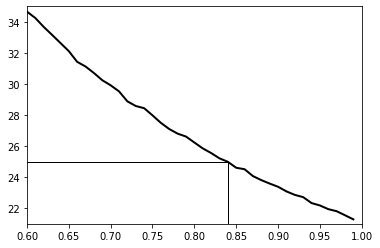

In [259]:
plt.plot(standardRates, WTAvs, linewidth = 2, color = "k")
plt.hlines(y = 25, xmax= 0.84, xmin = 0.5, linewidth = 1)
plt.xlim(0.6, 1)
plt.vlines(x = 0.84, ymax= 25, ymin = 16, linewidth = 1)
plt.ylim(21, 35)
plt.savefig('WTlengthFit.eps', dpi = 300)

In [243]:
diff = np.square(np.array(WTAvs)-25)
fitStandardRate = standardRates[np.where(min(diff)==diff)[0][0]]
fitStandardRate

0.8400000000000002

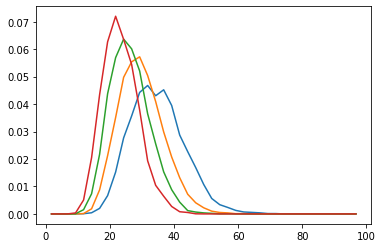

In [133]:
for j in range(0,40,10):
    plt.plot(WTdistsx[j], WTdistsy[j])
plt.savefig('WTlengths.eps', dpi = 300)

In [270]:
slowRates = np.arange(0.002,0.02,0.001)

kin4Avs = list()
bub2Avs = list()
nodes = list(WT.network.keys()) # this creates an iterable list of nodes

for k in range(0,len(nodes)-1):
        WT = maboss.copy_and_update_parameters(WT, {'$u_'+nodes[k]:fitStandardRate})
        WT = maboss.copy_and_update_parameters(WT, {'$d_'+nodes[k]:fitStandardRate})

for j in range(0,len(slowRates)):
    WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':400})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$slow':slowRates[j]})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$fast':fitStandardRate})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'sample_count':10000})
    WTEA = WT_allinputs.copy()
    WTEA.network.set_istate("SpindleAlign", [1,0]) 
    WTEA.network.set_istate("SACA_Nucleus", [1,0]) 
    mut_Bub2_OFF_EA = WTEA.copy()
    for name in "Bub2lowL_Nucleus Bub2lowL_Cytoplasm Bub2lowL_Bud Bub2lowL_dSPB Bub2lowL_mSPB Bub2highL_Nucleus Bub2highL_Cytoplasm Bub2highL_Bud Bub2highL_dSPB Bub2highL_mSPB".split(' '):
        mut_Bub2_OFF_EA.mutate(name, "OFF")
    mut_Kin4_OFF_EA = WTEA.copy()
    for name in "Kin4L_Nucleus Kin4L_Cytoplasm Kin4L_Bud Kin4L_dSPB Kin4L_mSPB".split(' '):
             mut_Kin4_OFF_EA.mutate(name, "OFF")
    run_Bub2_OFF_EA = mut_Bub2_OFF_EA.run()
    run_Kin4_OFF_EA = mut_Kin4_OFF_EA.run()
    exits_Bub2 = getExitTimes(run_Bub2_OFF_EA,5)
    exits_Kin4 = getExitTimes(run_Kin4_OFF_EA,5)
    #plt.figure()
    #plt.plot(exits_Bub2[0,:], exits_Bub2[1,:], 'r', label = u'bub2Δ')
    #plt.plot(exits_Kin4[0,:], exits_Kin4[1,:],'b', label = u"kin4Δ")
    #plt.legend()
    kin4Avs.append(exit2Av(exits_Kin4[0,:], exits_Kin4[1,:]))
    bub2Avs.append(exit2Av(exits_Bub2[0,:], exits_Bub2[1,:]))

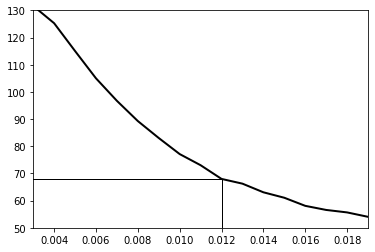

In [277]:
plt.plot(slowRates, kin4Avs, linewidth = 2, color = "k")
plt.hlines(y = 67.9852825, xmax= 0.012, xmin = 0, linewidth = 1)
plt.xlim(0.003, 0.019)
plt.vlines(x = 0.012, ymax= 67.9852825, ymin = 0, linewidth = 1)
plt.ylim(50, 130)
plt.savefig('slowRatesFit.eps', dpi = 300)

In [275]:
diff = np.square(np.array(kin4Avs)-70)
fitSlowRate = slowRates[np.where(min(diff)==diff)[0][0]]
fitSlowRate

0.012

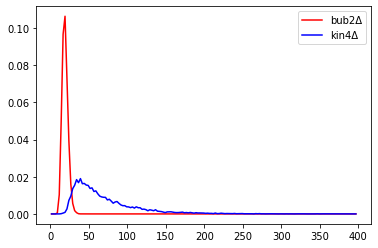

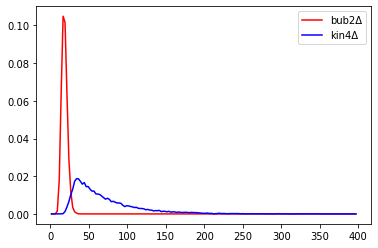

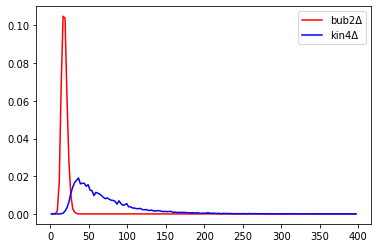

In [279]:
fastRates = [1,10,100]

kin4Avs = list()
bub2Avs = list()
nodes = list(WT.network.keys()) # this creates an iterable list of nodes

for k in range(0,len(nodes)-1):
        WT = maboss.copy_and_update_parameters(WT, {'$u_'+nodes[k]:fitStandardRate})
        WT = maboss.copy_and_update_parameters(WT, {'$d_'+nodes[k]:fitStandardRate})

for j in range(0,len(fastRates)):
    WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':400})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$slow':fitSlowRate})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$fast':fastRates[j]})
    WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'sample_count':10000})
    WTEA = WT_allinputs.copy()
    WTEA.network.set_istate("SpindleAlign", [1,0]) 
    WTEA.network.set_istate("SACA_Nucleus", [1,0]) 
    mut_Bub2_OFF_EA = WTEA.copy()
    for name in "Bub2lowL_Nucleus Bub2lowL_Cytoplasm Bub2lowL_Bud Bub2lowL_dSPB Bub2lowL_mSPB Bub2highL_Nucleus Bub2highL_Cytoplasm Bub2highL_Bud Bub2highL_dSPB Bub2highL_mSPB".split(' '):
        mut_Bub2_OFF_EA.mutate(name, "OFF")
    mut_Kin4_OFF_EA = WTEA.copy()
    for name in "Kin4L_Nucleus Kin4L_Cytoplasm Kin4L_Bud Kin4L_dSPB Kin4L_mSPB".split(' '):
             mut_Kin4_OFF_EA.mutate(name, "OFF")
    run_Bub2_OFF_EA = mut_Bub2_OFF_EA.run()
    run_Kin4_OFF_EA = mut_Kin4_OFF_EA.run()
    exits_Bub2 = getExitTimes(run_Bub2_OFF_EA,5)
    exits_Kin4 = getExitTimes(run_Kin4_OFF_EA,5)
    plt.figure()
    plt.plot(exits_Bub2[0,:], exits_Bub2[1,:], 'r', label = u'bub2Δ')
    plt.plot(exits_Kin4[0,:], exits_Kin4[1,:],'b', label = u"kin4Δ")
    plt.legend()
    kin4Avs.append(exit2Av(exits_Kin4[0,:], exits_Kin4[1,:]))
    bub2Avs.append(exit2Av(exits_Bub2[0,:], exits_Bub2[1,:]))

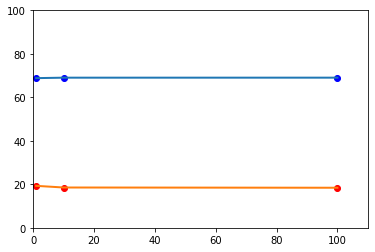

In [307]:

plt.scatter(fastRates, kin4Avs, color = "blue")
plt.plot(fastRates, kin4Avs, linewidth = 2)
plt.scatter(fastRates, bub2Avs, color = "red")
plt.plot(fastRates, bub2Avs, linewidth = 2)
plt.xlim(0, 110)
plt.ylim(0, 100)
plt.savefig('fastRatesFit.eps', dpi = 300)

In [5]:
# Reset to normal parameters
maxT = 400;
slowRate = 0.012; # fit parameter
fastRate = 1;
standardRate = 0.84; # fit parameter
maxT = 400;
theta = 0.3;
sigma = 0.07;
samples = 1000;
nodes = list(WT.network.keys()) # this creates an iterable list of nodes

for k in range(0,len(nodes)-1):
    WT = maboss.copy_and_update_parameters(WT, {'$u_'+nodes[k]:standardRate})
    WT = maboss.copy_and_update_parameters(WT, {'$d_'+nodes[k]:standardRate})

WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':maxT})
WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$slow':slowRate})
WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$fast':fastRate})
WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'sample_count':samples})


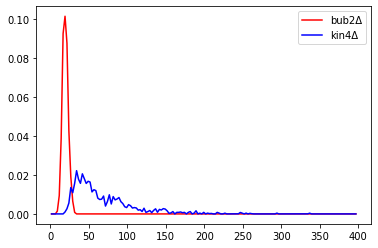

In [6]:
WTEA = WT_allinputs.copy()
WTEA.network.set_istate("SpindleAlign", [1,0]) 
WTEA.network.set_istate("SACA_Nucleus", [1,0]) 
mut_Bub2_OFF_EA = WTEA.copy()
for name in "Bub2lowL_Nucleus Bub2lowL_Cytoplasm Bub2lowL_Bud Bub2lowL_dSPB Bub2lowL_mSPB Bub2highL_Nucleus Bub2highL_Cytoplasm Bub2highL_Bud Bub2highL_dSPB Bub2highL_mSPB".split(' '):
    mut_Bub2_OFF_EA.mutate(name, "OFF")
mut_Kin4_OFF_EA = WTEA.copy()
for name in "Kin4L_Nucleus Kin4L_Cytoplasm Kin4L_Bud Kin4L_dSPB Kin4L_mSPB".split(' '):
         mut_Kin4_OFF_EA.mutate(name, "OFF")
run_Bub2_OFF_EA = mut_Bub2_OFF_EA.run()
run_Kin4_OFF_EA = mut_Kin4_OFF_EA.run()
exits_Bub2 = getExitTimes(run_Bub2_OFF_EA,5)
exits_Kin4 = getExitTimes(run_Kin4_OFF_EA,5)
plt.figure()
plt.plot(exits_Bub2[0,:], exits_Bub2[1,:], 'r', label = u'bub2Δ')
plt.plot(exits_Kin4[0,:], exits_Kin4[1,:],'b', label = u"kin4Δ")
plt.legend()
kin4av = exit2Av(exits_Kin4[0,:], exits_Kin4[1,:])
bub2av = exit2Av(exits_Bub2[0,:], exits_Bub2[1,:])


In [294]:
dt = 0.0025

sigmas = [0.11,0.12,0.13,0.14,0.15, 0.16]
varTimes = list()
for i in range(6):
    alltimes = list()
    for k in range(10000):
        alltimes.append(spindle_align(dt, sigmas[i], theta))
    varTimes.append(alltimes)
        

In [8]:
# define pdfs of relevant distributions
def fB(x):
    if isinstance(x,np.ndarray):
        y = list()
        for xi in x:
            if (xi<0) or (xi>400):
                yi = 0
            else :
                f = CubicSpline(exits_Bub2[0,:],exits_Bub2[1,:])
                yi = f(xi)
            y.append(yi)
        return(np.array(y))
    else :
        if (x<0) or (x>400):
            y = 0
        else :
            f = CubicSpline(exits_Bub2[0,:],exits_Bub2[1,:])
            y = f(x)
        return(y)
    
def fK(x):
    if isinstance(x,np.ndarray):
        y = list()
        for xi in x:
            if (xi<0) or (xi>400):
                yi = 0
            else :
                f = CubicSpline(exits_Kin4[0,:],exits_Kin4[1,:])
                yi = f(xi)
            y.append(yi)
        return(np.array(y))
    else :
        if (x<0) or (x>400):
            y = 0
        else :
            f = CubicSpline(exits_Kin4[0,:],exits_Kin4[1,:])
            y = f(x)
        return(y)

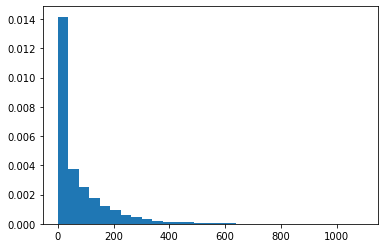

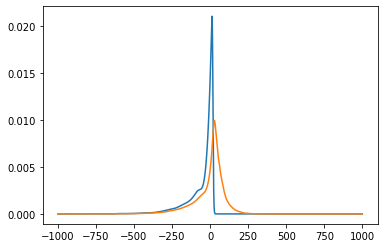

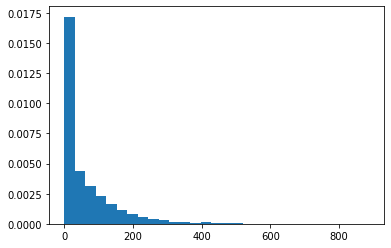

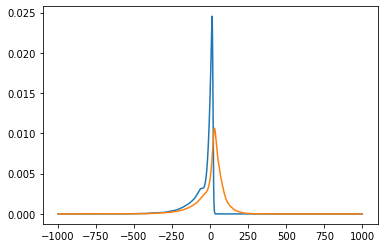

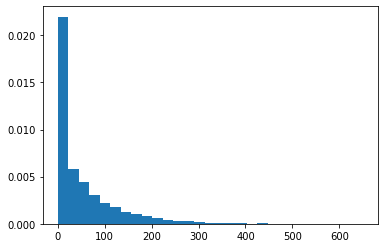

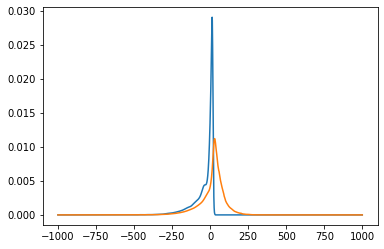

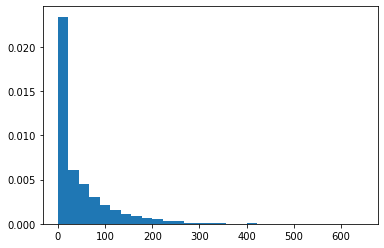

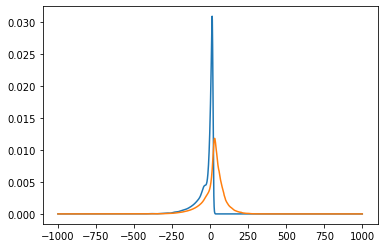

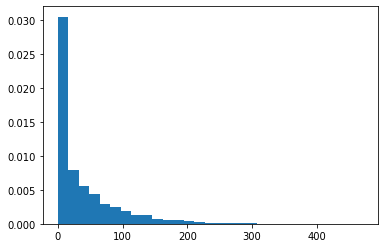

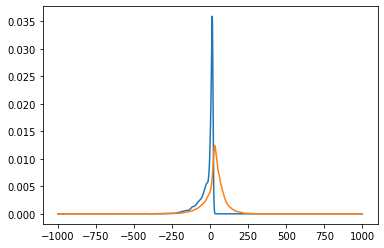

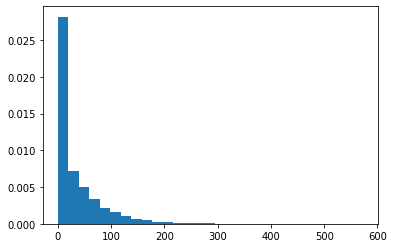

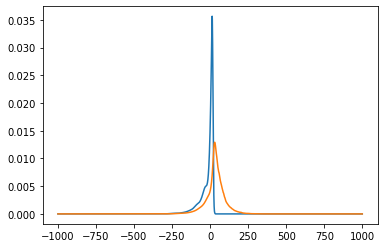

In [295]:
N = 2000
t = np.linspace(-1000,1000, num = N)
dt = t[1]-t[0]
Bub2_SPoC = list()
Kin4_SPoC = list()
for i in range(6):
    bins = np.linspace(0, max(varTimes[i]), 30)
    plt.figure()
    hist_times = plt.hist(varTimes[i],bins = bins,density  = True);
    hist_mids = (hist_times[1][1:len(hist_times[1])] + hist_times[1][0:(len(hist_times[1])-1)])/2
    def ft(x):
        if isinstance(x,np.ndarray):
            y = list()
            for xi in x:
                if (xi<0) or (xi>max(varTimes[i])):
                    yi = 0
                else :
                    f = CubicSpline(hist_mids,hist_times[0])
                    yi = f(xi)
                y.append(yi)
            return(np.array(y))
        else :
            if (x<0) or (x>max(varTimes[i])):
                y = 0
            else :
                f = CubicSpline(hist_mids,hist_times[0])
                y = f(x)
            return(y)
    T = ft(t)[::-1]
    Eb = fB(t)/sum(fB(t)) # normalise to ensure proper pdf
    Ek = fK(t)/sum(fK(t))
    Bub2_diffs = np.convolve(Eb, T, mode = "same")
    Kin4_diffs = np.convolve(Ek, T, mode = "same")
    plt.figure()
    plt.plot(t, Bub2_diffs)
    plt.plot(t, Kin4_diffs)
    tBub2_SPoC = sum(Bub2_diffs[0:(int(N/2))-2]+Bub2_diffs[1:(int(N/2))-1])*dt/2
    tKin4_SPoC = sum(Kin4_diffs[0:(int(N/2))-2]+Kin4_diffs[1:(int(N/2))-1])*dt/2
    Bub2_SPoC.append(tBub2_SPoC)
    Kin4_SPoC.append(tKin4_SPoC)
    

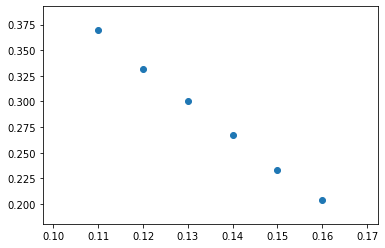

In [296]:
plt.scatter(sigmas,Kin4_SPoC)

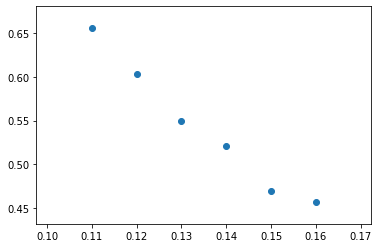

In [297]:
plt.scatter(sigmas,Bub2_SPoC)

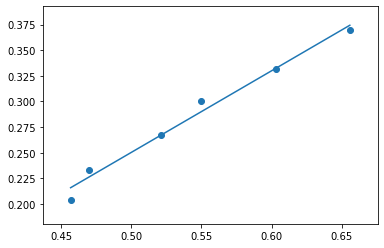

In [298]:
plt.scatter(Bub2_SPoC,Kin4_SPoC)
plt.plot(np.unique(Bub2_SPoC), np.poly1d(np.polyfit(Bub2_SPoC, Kin4_SPoC, 1))(np.unique(Bub2_SPoC)))

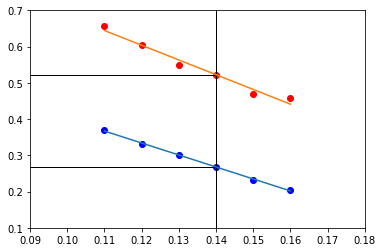

In [308]:
plt.scatter(sigmas,Kin4_SPoC, color = "blue")
plt.plot(np.unique(sigmas), np.poly1d(np.polyfit(sigmas, Kin4_SPoC, 1))(np.unique(sigmas)))
plt.scatter(sigmas,Bub2_SPoC, color = "red")
plt.plot(np.unique(sigmas), np.poly1d(np.polyfit(sigmas, Bub2_SPoC, 1))(np.unique(sigmas)))

plt.hlines(y =  0.5213541537064926, xmax= 0.14, xmin = 0, linewidth = 1)
plt.hlines(y =  0.2670218482471062, xmax= 0.14, xmin = 0, linewidth = 1)
plt.xlim(0.09, 0.18)
plt.vlines(x = 0.14, ymax= 1, ymin = 0, linewidth = 1)
plt.ylim(0.1, 0.7)
plt.savefig('sigmaFit.eps', dpi = 300)